# Importing Dataset from kaggle

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-in-the-dat-ii/sample_submission.csv
/kaggle/input/cat-in-the-dat-ii/train.csv
/kaggle/input/cat-in-the-dat-ii/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load train and test datasets

In [3]:
train_df = pd.read_csv('/kaggle/input/cat-in-the-dat-ii/train.csv')
train_df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [4]:
y = train_df.pop('target')

# check that we are dealing with binary classification
y.unique()

array([0, 1])

<AxesSubplot:>

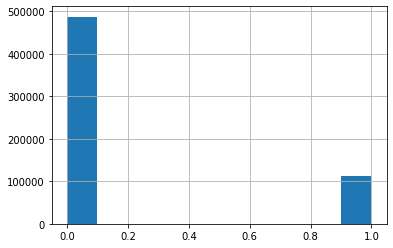

In [5]:
# the target value looks skewed!
# so we need to be careful evaluating model results
# i'm gonna use AUC_ROC and f1 scores here to evaluate model performance
y.hist()

In [6]:
test_df = pd.read_csv('/kaggle/input/cat-in-the-dat-ii/test.csv')
test_df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,...,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
1,600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,...,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
2,600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,...,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
3,600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,...,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
4,600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,...,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


In [7]:
print(f'Train df shape: {train_df.shape}')
print(f'Test df shape: {test_df.shape}')

Train df shape: (600000, 24)
Test df shape: (400000, 24)


## 2. Explore the data

In [8]:
# check duplicated rows
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

In [9]:
# from competition:
# The data contains binary features (bin_*), 
# nominal features (nom_*), 
# ordinal features (ord_*) as well as (potentially cyclical) day (of the week) and month features. 
# The string ordinal features ord_{3-5} are lexically ordered according to string.ascii_letters.

train_df.columns, test_df.columns

(Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
        'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
        'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month'],
       dtype='object'),
 Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
        'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
        'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month'],
       dtype='object'))

In [10]:
# concatenate both dataframes to preprocess both train and test dataframes

df = pd.concat([train_df.drop(columns = ['id']), test_df.drop(columns = ['id'])]).reset_index(drop=True)
df.shape

(1000000, 23)

In [11]:
df.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0


In [12]:
def get_features_by_prefix(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    return df.loc[:, [col for col in df.columns if col.startswith(prefix)]]

### 2.1 Binary data

In [13]:
# Lets explore binary features first

bin_features = get_features_by_prefix(df, 'bin_')
bin_features.head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0.0,0.0,0.0,F,N
1,1.0,1.0,0.0,F,Y
2,0.0,1.0,0.0,F,N
3,NaN,0.0,0.0,F,N
4,0.0,NaN,0.0,T,N


In [14]:
bin_features.isna().sum() / len(bin_features) # in %

bin_0    0.029795
bin_1    0.030041
bin_2    0.029902
bin_3    0.029965
bin_4    0.029998
dtype: float64

In [15]:
# check bin_3/bin_4 values 
bin_features['bin_3'].unique(), bin_features['bin_4'].unique()

(array(['F', 'T', nan], dtype=object), array(['N', 'Y', nan], dtype=object))

In [16]:
bin_features['bin_3'] = bin_features['bin_3'].map({'F': 0, 'T' : 1})
bin_features['bin_4'] = bin_features['bin_4'].map({'N': 0, 'Y' : 1})
bin_features.head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,0.0
4,0.0,NaN,0.0,1.0,0.0


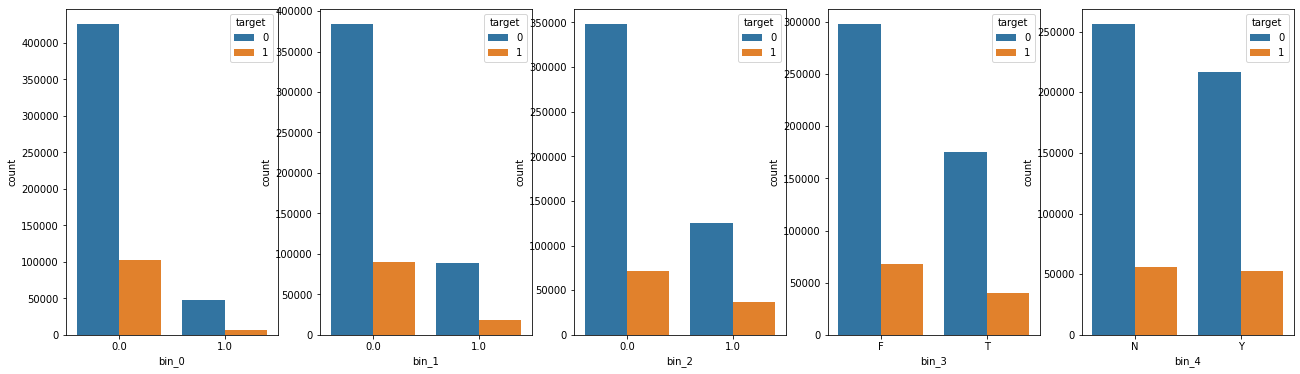

In [17]:
fig, ax = plt.subplots(1, len(bin_features.columns), figsize=(22, 6))
for i, col in enumerate(bin_features.columns):
    plt.subplot(1, 5, i + 1)
    sns.countplot(x = col, hue = y, data = train_df)

plt.show()

<AxesSubplot:>

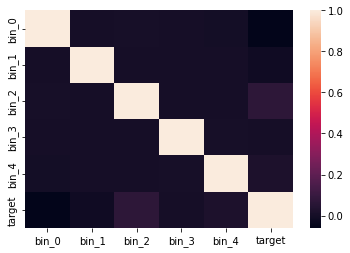

In [18]:
import seaborn as sns

sns.heatmap(pd.concat([bin_features, y], axis = 1).corr())

In [19]:
# fill NaN values with most occurring class for each column
#bin_features.fillna(bin_features.mode().iloc[0], inplace = True)
#bin_features.head()

# Filling NA values now is in the end of preprocessing!

### 2.2 Nominal Features

In [20]:
# Nominal features - categorical features without any order of precedence

nom_features = get_features_by_prefix(df, 'nom_')
nom_features.head(20)

,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9
0,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990
1,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af
2,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN
3,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57
4,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c
5,Red,Triangle,Lion,China,Bassoon,a2e1bf0b1,ae6737c29,8c30b9b0b,690411ac0,05afc0f8b
6,Red,Triangle,Hamster,Costa Rica,Bassoon,87a5be0d7,cdc35bd00,1cba571fa,b8e63cace,4d3766412
7,Red,Triangle,Axolotl,Finland,Bassoon,104aee31d,2a50808ba,81d67e1bb,bd9643a20,a651dec43
8,Blue,Polygon,Hamster,Russia,Oboe,024efa364,a4a81ab45,429114096,94c5fd40c,NaN
9,Red,Polygon,Hamster,Finland,Theremin,9fa084b36,e7aa94f40,56d35c774,0279391c5,79b29d54c


In [21]:
nom_features.isna().sum() / len(nom_features) # in %

nom_0    0.030314
nom_1    0.030103
nom_2    0.030214
nom_3    0.030297
nom_4    0.030028
nom_5    0.029690
nom_6    0.030143
nom_7    0.030006
nom_8    0.029711
nom_9    0.030133
dtype: float64

In [22]:
for col in nom_features.columns:
    print(f'Column: "{col}", num of values: {len(nom_features[col].unique())}')

Column: "nom_0", num of values: 4
Column: "nom_1", num of values: 7
Column: "nom_2", num of values: 7
Column: "nom_3", num of values: 7
Column: "nom_4", num of values: 5
Column: "nom_5", num of values: 1221
Column: "nom_6", num of values: 1521
Column: "nom_7", num of values: 223
Column: "nom_8", num of values: 223
Column: "nom_9", num of values: 2219


In [23]:
nom_columns = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
for col in nom_columns:
    print(nom_features[col].dropna().unique())

['Red' 'Blue' 'Green']
['Trapezoid' 'Star' 'Circle' 'Triangle' 'Polygon' 'Square']
['Hamster' 'Axolotl' 'Lion' 'Dog' 'Cat' 'Snake']
['Russia' 'Canada' 'Finland' 'Costa Rica' 'China' 'India']
['Bassoon' 'Theremin' 'Oboe' 'Piano']


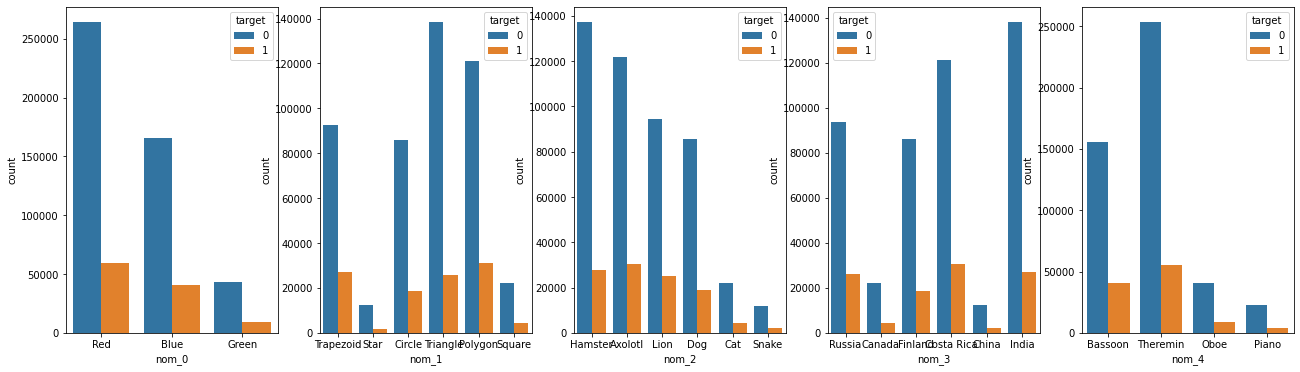

In [24]:
fig, ax = plt.subplots(1, len(nom_columns), figsize=(22, 6))
for i, col in enumerate(nom_columns):
    plt.subplot(1, len(nom_columns), i + 1)
    sns.countplot(x = col, hue = y, data = train_df)

plt.show()

<AxesSubplot:>

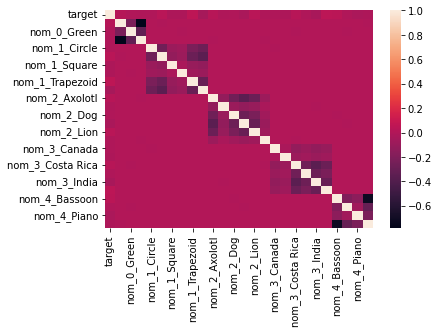

In [25]:
sns.heatmap(pd.get_dummies(pd.concat([nom_features.loc[:, nom_features.columns.isin(nom_columns)], y], axis = 1)).corr())

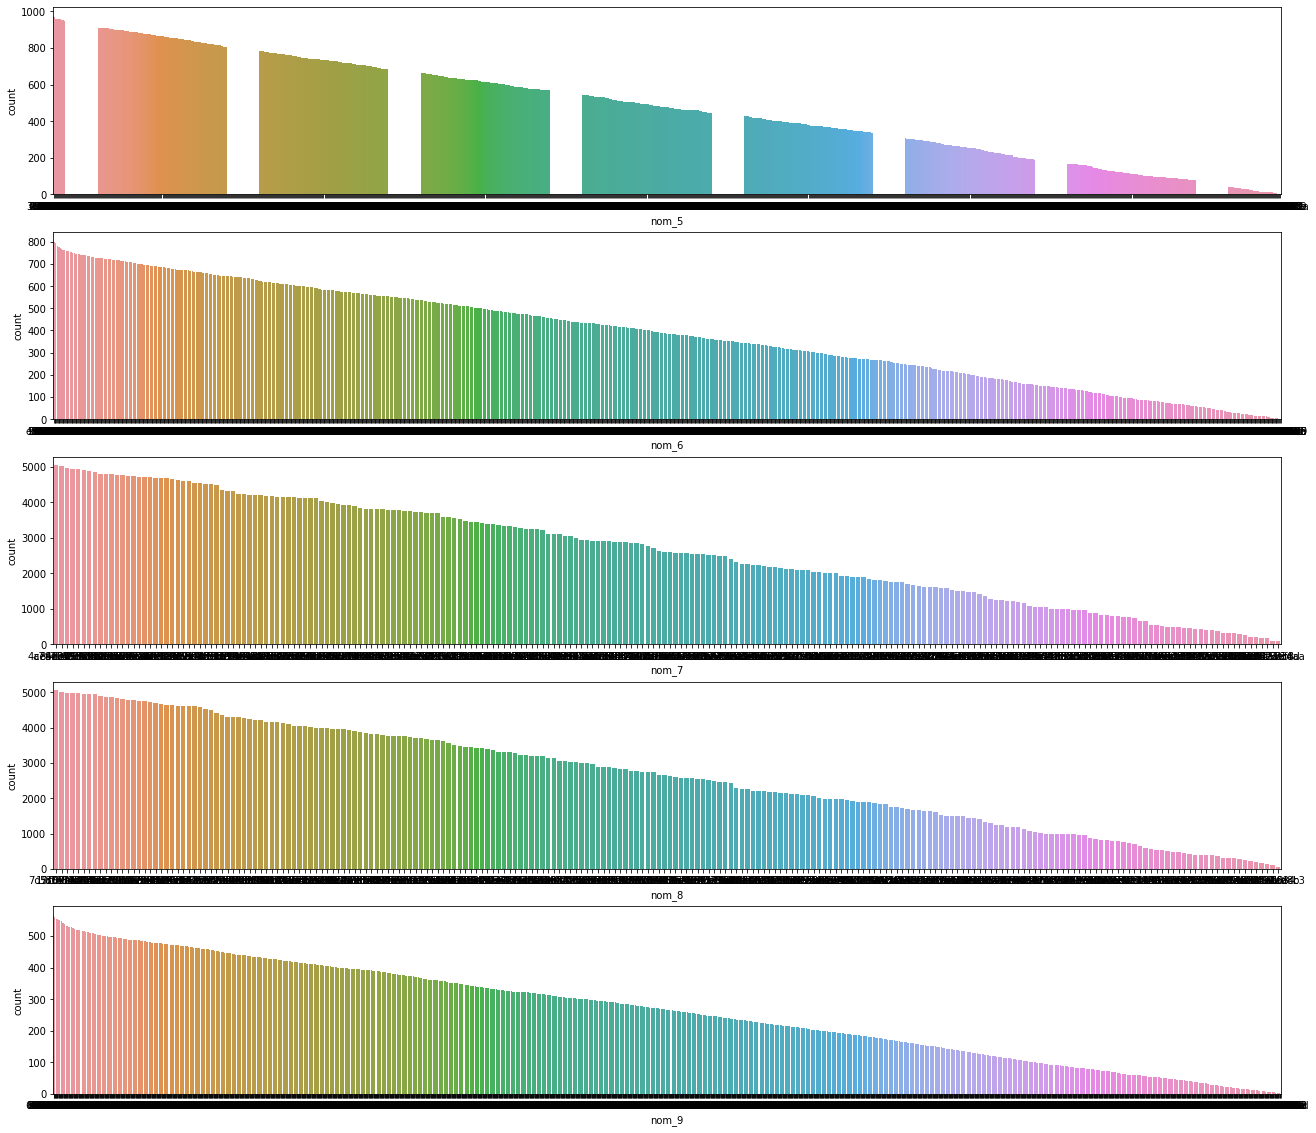

In [26]:
# lets check values distribution in train dataset
other_columns = [c for c in nom_features.columns if c not in nom_columns]
l = len(other_columns)
 
fig, ax = plt.subplots(l, 1, figsize=(22, 20))
for i, col in enumerate(other_columns):
    plt.subplot(l, 1, i + 1)
    sns.countplot(x = col, data = train_df, order = train_df[col].value_counts().index)

plt.show()

Nominal features should be transformed into 'dummy' variables. But taking into consideration the number of unique values we will probably get a huge dataframe!

In [27]:
#nom_features.fillna('NA', inplace = True)
#nom_features.head(10)

### 2.3 Ordinal features

In [28]:
# Ordinal features - categorical features with order of precedence

ord_features = get_features_by_prefix(df, 'ord_')
ord_features.head()

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
0,3.0,Contributor,Hot,c,U,Pw
1,3.0,Grandmaster,Warm,e,X,pE
2,3.0,NaN,Freezing,n,P,eN
3,1.0,Novice,Lava Hot,a,C,NaN
4,3.0,Grandmaster,Cold,h,C,OZ


In [29]:
ord_features.isna().sum() / len(ord_features) # in %

ord_0    0.030181
ord_1    0.030208
ord_2    0.030180
ord_3    0.029969
ord_4    0.029863
ord_5    0.029760
dtype: float64

In [30]:
for col in ord_features.columns:
    print(f'Column: "{col}", num of values: {len(ord_features[col].unique())}')

Column: "ord_0", num of values: 4
Column: "ord_1", num of values: 6
Column: "ord_2", num of values: 7
Column: "ord_3", num of values: 16
Column: "ord_4", num of values: 27
Column: "ord_5", num of values: 191


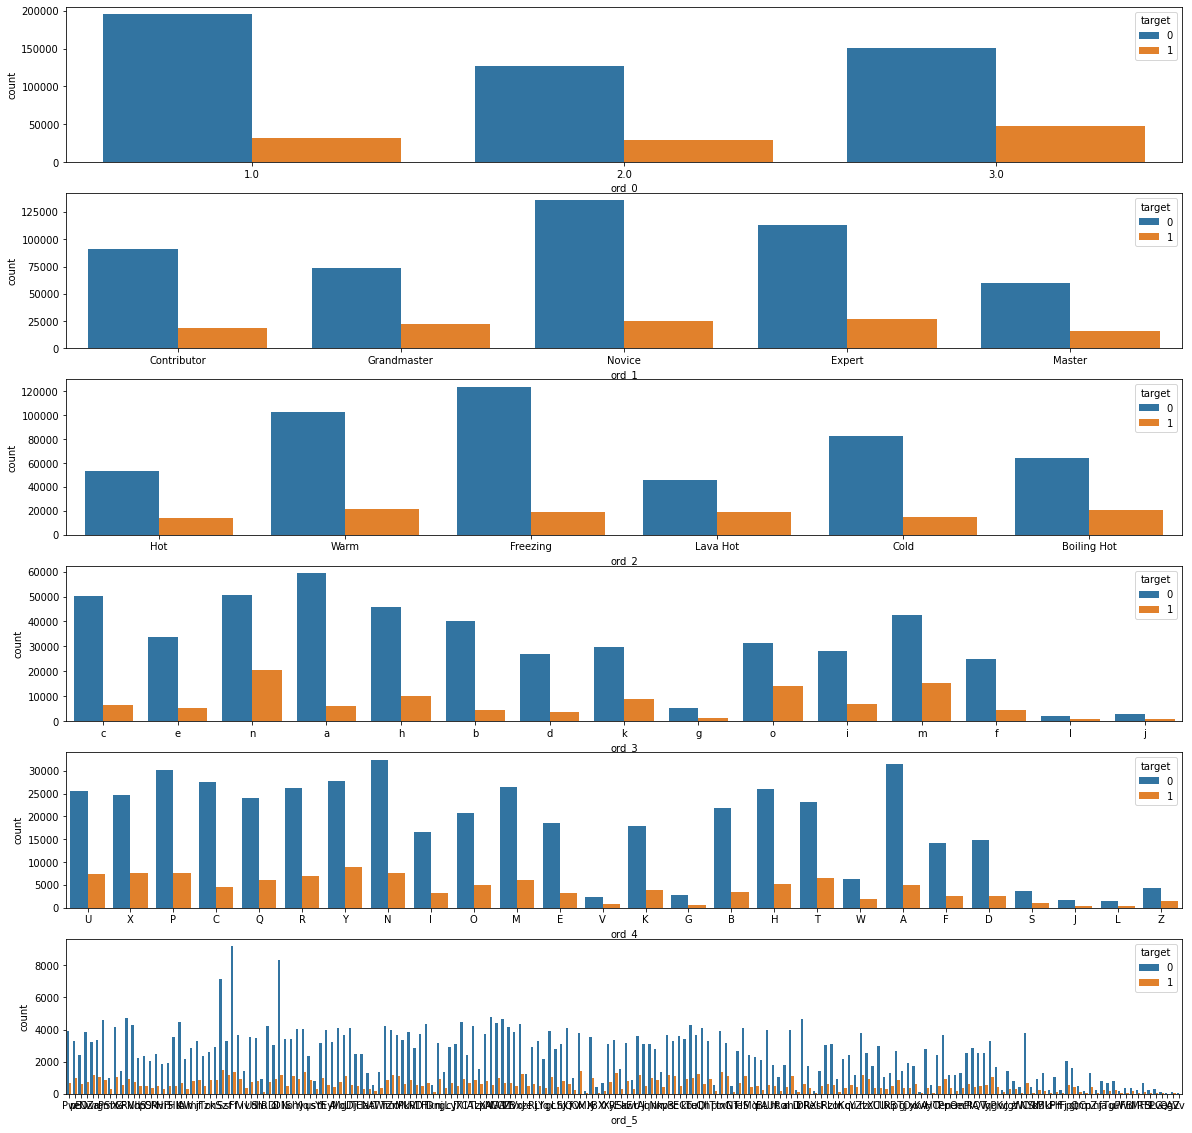

In [31]:
fig, ax = plt.subplots(len(ord_features.columns), 1, figsize=(20, 20))
for i, col in enumerate(ord_features.columns):
    plt.subplot(len(ord_features.columns), 1, i + 1)
    sns.countplot(x = col, hue = y, data = train_df)

plt.show()

In [32]:
print(sorted(ord_features.ord_3.dropna().unique()))
print(sorted(ord_features.ord_4.dropna().unique()))
print(sorted(ord_features.ord_5.dropna().unique()))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['AG', 'AI', 'AU', 'AW', 'Ay', 'BL', 'BX', 'Bx', 'CN', 'CU', 'Cn', 'DI', 'DN', 'DR', 'DT', 'Dj', 'Dn', 'EC', 'Ey', 'FB', 'FH', 'Fl', 'GZ', 'HF', 'HK', 'HO', 'Hk', 'IA', 'IS', 'Ib', 'In', 'Io', 'Iq', 'JQ', 'JT', 'Ji', 'Kq', 'LS', 'LY', 'Lo', 'MF', 'MU', 'MV', 'MX', 'Mg', 'Mq', 'NS', 'NT', 'Nh', 'OM', 'OZ', 'Oe', 'Ox', 'PG', 'PS', 'Pk', 'Pw', 'QV', 'Qm', 'RB', 'RD', 'RT', 'RV', 'Re', 'Rj', 'Ro', 'Rv', 'Rz', 'SL', 'SS', 'Sk', 'Sz', 'TH', 'TL', 'TP', 'TZ', 'Tg', 'Ty', 'Tz', 'US', 'UV', 'WC', 'WW', 'Wr', 'XC', 'XI', 'XM', 'XR', 'XU', 'YJ', 'Yb', 'Yi', 'Yr', 'Zv', 'aA', 'aE', 'al', 'be', 'cR', 'cY', 'cg', 'cy', 'dh', 'dp', 'eA', 'eN', 'ep', 'fF', 'fO', 'fV', 'fe', 'gK', 'gL', 'gV', 'gc', 'gj', 'gt', 'hG', 'hT', 'ht', 'hx', 'iS', 'iv', 'ja', 'jf', 'jp', 'kB', 'kP', 'kT', 'kv', 'lA', 'lR', 

### 2.4 Day and month features

In [33]:
day_feature = get_features_by_prefix(df, 'day')
month_feature = get_features_by_prefix(df, 'month')
dm_features = pd.concat([day_feature, month_feature], axis = 1)
dm_features.head(10)

,day,month
0,6.0,3.0
1,7.0,7.0
2,5.0,9.0
3,3.0,3.0
4,5.0,12.0
5,3.0,4.0
6,5.0,6.0
7,1.0,1.0
8,6.0,3.0
9,1.0,8.0


In [34]:
dm_features.isna().sum() / len(dm_features) # in %

day      0.029977
month    0.029972
dtype: float64

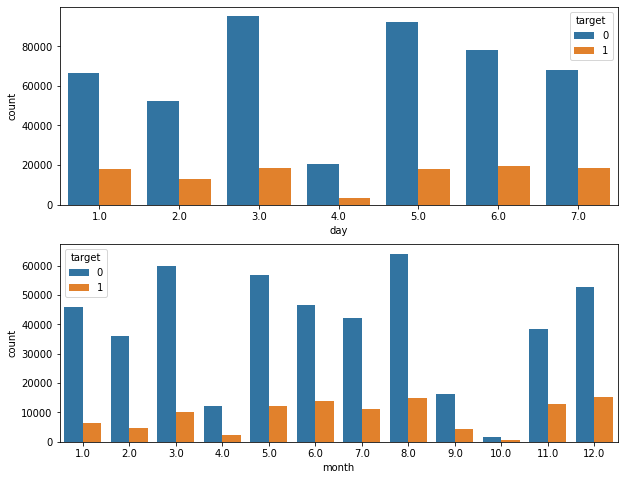

In [35]:
# there is no explicit correlation between target and work days/weekends and seasons

l = len(dm_features.columns)

fig, ax = plt.subplots(l, 1, figsize = (10, 8))
for i, col in enumerate(dm_features.columns):
    plt.subplot(l, 1, i + 1)
    sns.countplot(x = col, hue = y, data = train_df)

plt.show()

### 2.5 Final dataframe

In [36]:
from sklearn import preprocessing

In [37]:
final_df = pd.concat([bin_features, nom_features, ord_features, dm_features], axis = 1).fillna('NA')

for col in final_df.columns:
    lbl_enc = preprocessing.LabelEncoder()
    final_df[col] = lbl_enc.fit_transform(final_df.loc[:, col].astype(str).values)
    
final_df.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,0,0,3,5,3,6,0,...,1,27,2,0,3,3,21,57,5,5
1,1,1,0,0,1,3,4,0,5,4,...,69,2113,2,2,6,5,24,151,6,9
2,0,1,0,0,0,3,1,3,0,0,...,102,1400,2,4,2,14,16,106,4,11
3,2,0,0,0,0,3,0,3,3,4,...,171,2168,0,5,4,1,2,46,2,5
4,0,2,0,1,0,3,6,3,2,1,...,151,1748,2,2,1,8,2,51,4,3


In [38]:
X = final_df.iloc[:len(train_df), :]
X_test = final_df.iloc[len(train_df):, :]
X.shape, X_test.shape

((600000, 23), (400000, 23))

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 1)
X_train.shape, X_val.shape

((540000, 23), (60000, 23))

In [40]:
X_train_arr = [X_train[c].values for c in X_train.columns]
X_val_arr = [X_val[c] for c in X_val.columns]
X_test_arr = [X_test[c] for c in X_test.columns]

## 3. Model

### Embedding layers

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras import callbacks

In [42]:
from math import log2

In [43]:
# prepare each input head
input_layers = []
output_layers = []
for col in final_df.columns:
    
    n_labels = len(final_df.loc[:, col].unique()) + 1
    n_outputs = int(log2(n_labels))
    
    input_layer = Input(shape=(1,))
    emb_layer = Embedding(n_labels, n_outputs, name = col)(input_layer)
    
    input_layers.append(input_layer)
    output_layers.append(Flatten()(emb_layer))

2022-08-30 23:53:33.666570: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Final Model

In [44]:
x = Concatenate()(output_layers)
x = Dropout(0.2)(x)
x = Dense(300, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(200, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(8, activation = 'relu')(x)
output = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = input_layers, outputs = output)

opt = tf.keras.optimizers.Adam(learning_rate = 5e-5)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc', 'AUC'])
#model.summary()

In [45]:
es = callbacks.EarlyStopping(monitor='val_auc', mode = 'max', patience = 5, verbose = 1, restore_best_weights = True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', mode = 'max', factor = 0.1, patience = 3, verbose = 1)

In [46]:
history = model.fit(X_train_arr, y_train.values, epochs = 100, batch_size = 1000,
                   validation_data = (X_val_arr, y_val.values), callbacks = [es, rlr])

2022-08-30 23:53:34.690559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
540/540 [==============================] - 16s 22ms/step - loss: 0.5336 - acc: 0.8105 - auc: 0.5181 - val_loss: 0.4709 - val_acc: 0.8122 - val_auc: 0.6647
Epoch 2/100
540/540 [==============================] - 11s 20ms/step - loss: 0.4542 - acc: 0.8129 - auc: 0.6949 - val_loss: 0.4326 - val_acc: 0.8122 - val_auc: 0.7491
Epoch 3/100
540/540 [==============================] - 10s 19ms/step - loss: 0.4228 - acc: 0.8134 - auc: 0.7468 - val_loss: 0.4078 - val_acc: 0.8186 - val_auc: 0.7748
Epoch 4/100
540/540 [==============================] - 11s 20ms/step - loss: 0.4120 - acc: 0.8204 - auc: 0.7636 - val_loss: 0.4026 - val_acc: 0.8245 - val_auc: 0.7822
Epoch 5/100
540/540 [==============================] - 10s 19ms/step - loss: 0.4081 - acc: 0.8219 - auc: 0.7703 - val_loss: 0.4004 - val_acc: 0.8255 - val_auc: 0.7850
Epoch 6/100
540/540 [==============================] - 10s 19ms/step - loss: 0.4052 - acc: 0.8228 - auc: 0.7749 - val_loss: 0.3992 - val_acc: 0.8260 - val_auc: 0.786

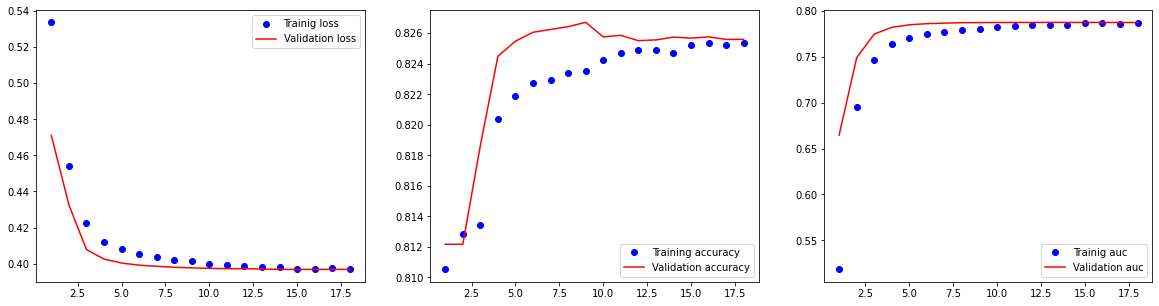

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 5))

#loss
plt.subplot(1,3,1)
plt.plot(epochs, loss, 'bo', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

#accuracy
plt.subplot(1,3,2)
plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

#auc
plt.subplot(1,3,3)
plt.plot(epochs, auc, 'bo', label = 'Trainig auc')
plt.plot(epochs, val_auc, 'r', label = 'Validation auc')
plt.legend()
 
plt.show()

## Submission

In [48]:
submission = test_df.id.to_frame()
submission['target'] = [pred[0] for pred in model.predict(X_test_arr)]
submission.to_csv('sub.csv', index = False)